## Please read before running the code:

##### We use :
##### - Anaconda which is an open source tool for managing packages
##### - Web-based jupyter notebook containing code, data, text and graphs etc
##### - Install Anaconda and Jupyter Notebook following the instructions here: https://mas-dse.github.io/startup/anaconda-windows-install/ 
##### - Jupyter notebook can be launched in a conda environment (from Anaconda)
##### - Packages can be downloaded through Anaconda prompt with [conda install / pip install 'package name']
##### - We recommend you to create a Github repository where the code and the data can be saved together and shared with multiple people
##### - Github for M+ Conservation can access here: https://github.com/MPlusConservation/EMS_Data




  

### 1. Import packages needed to run the code
#### The code details:
- for packages, download as follows: 

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import matplotlib.dates as dates
import glob
import pandas as pd
import os
from scipy.interpolate import CubicSpline
import datetime
import csv
from dateutil.parser import parse
import math
import ipywidgets as widgets
from ipywidgets import interactive
from psychrochart import PsychroChart
from scipy.interpolate import splrep, BSpline


### 2. Get data from path with a csv format

#### User input/check
##### 1. path = where you files are stored. Your file should be saved as a csv format
##### 2. check if the code finds the correct files with print function 
- names = each name of csv files
- num_sensors = number of sensors (= number of files)

In [1]:
path = r'.\test'
filenames = glob.glob(path + "/*.csv")
names = [os.path.splitext(x)[0] for x in [os.path.basename(x) for x in filenames]]
num_sensors = str(int(len(names)))

print(names)
print(num_sensors)

NameError: name 'glob' is not defined

### 3. Define date/time

#### No user input required. Just run the cell.
##### The code details:
- The function below [is_date] is looking for date-time format



In [29]:
def is_date(string, fuzzy=False):
    """
    Return whether the string can be interpreted as a date/time

    :param string: str, string to check for date
    :param fuzzy: bool, ignore unknown tokens in string if True
    """
    try: 
        parse(string, fuzzy=fuzzy)
        return True

    except ValueError:
        return False


### 4. Read in data 

#### No user input required. Just run the cell. 

#### Please check your data before reading in the code:
##### - All files have to have a same time period (if A file has 1 year data B file has to have 1 year data too, otherwise it may cause issues with plots)
##### - If you have multiple files that have different time period, we recommend you to run the code separately
##### - Date/Time should be the first column
##### - Every file should be a single location


#### The code details:
- Loop below goes through to read each file
- [head_index] and [tail_index] look for the row of date-time format and will read in the data
- We specify the header as [head_index], meaing the [head_index] row contains the columns of titles such as Date/Time, Temperature and Relative Humidity
- Make sure which columns should be read in. Note that python starts from 0; [Column A] equals as [Column 0]
- Rename columns title such as DateTime, Temp, and RH



In [30]:
dfs = []
for filename in filenames:
    print(filename)
    head_index = 0
    with open (filename,'r') as csv_file:
        reader =csv.reader(csv_file)
        for row in reader:
            if row != []:
                if is_date(row[0]):
                    break
                head_index = head_index + 1
            else:
                head_index = head_index + 1

   
    head_index = head_index - 1
    
   
    tail_index = 0
    with open (filename,'r') as csv_file:
        reader =csv.reader(csv_file)
        for row in reversed(list(csv.reader(csv_file))):
            if row != []:
                if is_date(row[0]):
                    break
                tail_index = tail_index + 1
            else:
                tail_index = tail_index + 1

    df= pd.read_csv(filename, header=head_index, infer_datetime_format=True, skip_blank_lines=False, usecols=[i for i in range(3)], low_memory = False)
    df.drop(df.tail(tail_index).index, inplace=True)

    #User input
    df.rename(columns={df.columns[0]: 'DateTime', df.columns[1]: 'Temp', df.columns[2]: 'RH'}, inplace=True) 
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['Temp']= pd.to_numeric(df["Temp"])
    df['RH']= pd.to_numeric(df["RH"])

    dfs.append(df)
                    

.\test\B2Xray_1yr.csv
.\test\B2Xray_1yr_summer.csv
.\test\B2Xray_1yr_winter.csv


### 5. Sampling data and Time-series plots
#### User input/check
##### 1. num_samp: select the average sampling time period you'd like to analyse (e.g. 1D = 1day)
##### 2. plot data
- ax[0] = Relative Humidity (%) / ax[1] = Temperature (°C)
- set target ranges and axis scale
- You can switch to different sensors using the bar (on the left top)


In [3]:
num_samp = str('1D')

%matplotlib inline

def f(sensor):
    
    AvRH = dfs[sensor].set_index('DateTime').resample(num_samp).mean().reset_index().RH 
    Std_RH = dfs[sensor].set_index('DateTime').resample(num_samp).std().reset_index().RH 
    AvT = dfs[sensor].set_index('DateTime').resample(num_samp).mean().reset_index().Temp 
    Std_T = dfs[sensor].set_index('DateTime').resample(num_samp).std().reset_index().Temp 
    Avdate = dfs[sensor].set_index('DateTime').resample(num_samp).mean().reset_index().DateTime 

    PlusRHSTD=[x+y for x,y in zip(AvRH, Std_RH)]
    MinusRHSTD=[x-y for x,y in zip(AvRH, Std_RH)]
    PlusTSTD=[x+y for x,y in zip(AvT, Std_T)]
    MinusTSTD=[x-y for x,y in zip(AvT, Std_T)]
    

    f, ax = plt.subplots(2,1,figsize=(10,9),sharex=True)

    # Relative Humidity (%)
    ax[0].axes.get_xaxis().set_visible(False) 
    ax[0].axes.get_yaxis().set_visible(True) 
    ax[0].scatter(Avdate,AvRH, s = 2, color="None", edgecolor ="blue", alpha =1)
    ax[0].fill_between(Avdate,MinusRHSTD,PlusRHSTD, color = "blue", edgecolor ="None", alpha =0.3 )
    ax[0].set_title(names[sensor], size = 14)
    ax[0].set_ylabel('RH (%)', size = 14)
    ax[0].axhline(50,linestyle='--', lw=1, color="blue", alpha =0.3)
    #user input for target range
    ax[0].fill_between(Avdate,40,60, color="blue", edgecolor ="None", alpha =0.05 )
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['left'].set_visible(True)
    #user input for y axis
    ax[0].set_ylim([0,100])

    # Temperature(°C)
    ax[1].axes.get_xaxis().set_visible(True) 
    ax[1].axes.get_yaxis().set_visible(True) 
    ax[1].scatter(Avdate,AvT, s = 2, color="None", edgecolor ="red", alpha =0.8)
    ax[1].fill_between(Avdate,MinusTSTD,PlusTSTD, color="red", edgecolor ="None", alpha =0.3)
    ax[1].axhline(20,linestyle='--', lw=1, color="blue", alpha =0.3)
    #user input for target range
    ax[1].fill_between(Avdate,20,24, color="blue", edgecolor ="None", alpha =0.05)
    ax[1].set_ylabel('Temp (°C)', size = 14)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['bottom'].set_visible(True)
    ax[1].spines['left'].set_visible(True)
    #user input for y axis 
    ax[1].set_ylim([10,38])


    f.tight_layout()
    plt.show()
    f.savefig('Timeseries')

interactive_plot = interactive(f, sensor=(0, len(names)-1))
output = interactive_plot.children[-1]
interactive_plot


NameError: name 'interactive' is not defined

### 6. Box plots
#### User input/check
##### 1. plot data
- ax[0] = Relative Humidity (%) / ax[1] = Temperature (°C)
- set axis scale

['B2Xray_1yr', 'B2Xray_1yr_summer', 'B2Xray_1yr_winter']


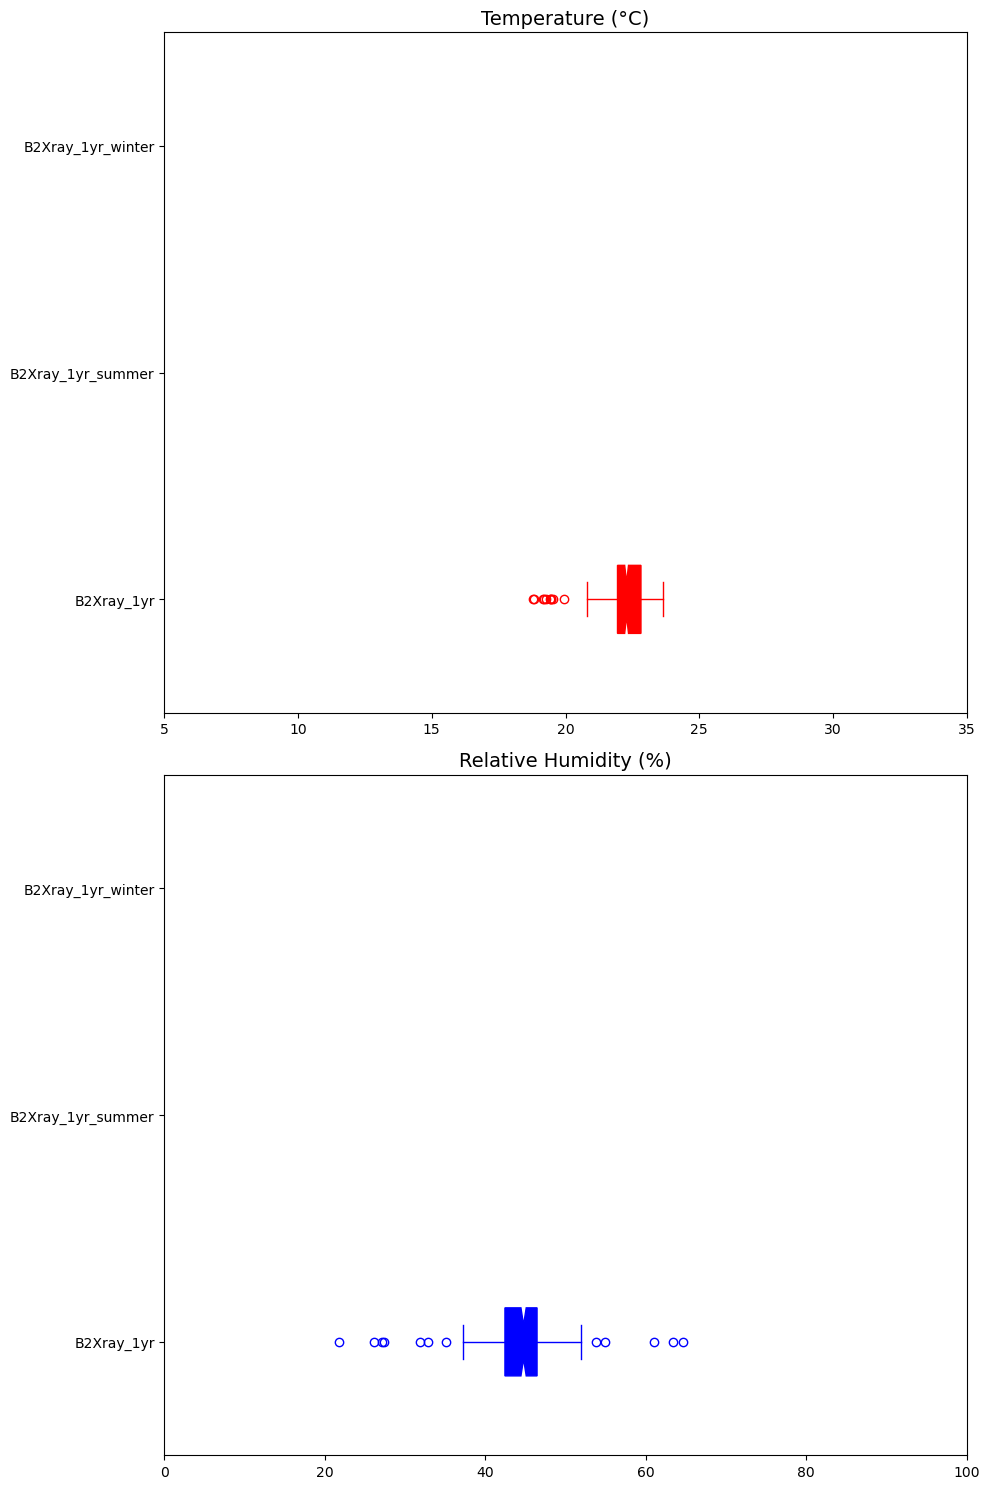

In [32]:
# Temperature (°C)

data_temp = []
data_temp = pd.DataFrame(data_temp)

i = 0
for name in names:
    data_temp[name] = dfs[i].set_index('DateTime').resample(num_samp).mean().reset_index().Temp
    i = i + 1
print(names)

data_temp = data_temp.to_numpy()

f2, ax = plt.subplots(2,1,figsize=(10,15),sharex=False)
ax[0].axes.get_xaxis().set_visible(True)
ax[0].axes.get_yaxis().set_visible(True) 
c = "red"
ax[0].boxplot(data_temp, patch_artist = True,
                notch ='True', vert = 0,
                boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c))
ax[0].set_yticklabels(names)
ax[0].set_title("Temperature (°C)", size = 14)
#user input for x axis 
ax[0].set_xlim([5,35])


# Relative Humidity (%)

data_RH = []
data_RH = pd.DataFrame(data_RH)

i = 0
for name in names:
    data_RH[name] = dfs[i].set_index('DateTime').resample(num_samp).mean().reset_index().RH
    i = i + 1

data_rh = data_RH.to_numpy()

ax[1].axes.get_xaxis().set_visible(True) #set X axis 
ax[1].axes.get_yaxis().set_visible(True) #set Y axis
c = "blue"
ax[1].boxplot(data_rh, patch_artist = True,
                notch ='True', vert = False,
                boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c))
ax[1].set_yticklabels(names)
ax[1].set_title("Relative Humidity (%)", size = 14)
#user input for x axis 
ax[1].set_xlim([0,100])

f2.tight_layout()
plt.show()
f2.savefig('Boxplot')


### 7. Psychrometric chart

#### User input/check
##### 1. plot data
- set target ranges
- sensor number: you can switch to different sensors changing sensor nuumber. Note that python starts from 0

In [ ]:
%matplotlib inline
%matplotlib widget
from psychrochart import PsychroChart, load_config

chart = PsychroChart('minimal')

#user input for target ranges (points_x and points_y)
zones_conf = {
    "zones":[{
            "zone_type": "dbt-rh",
            "style": {"edgecolor": [1.0, 0.749, 0.0, 0.8],
                      "facecolor": [1.0, 0.749, 0.0, 0.6],
                      "linewidth": 2,
                      "linestyle": "--"},
            "points_x": [20, 24], # Temperature (°C)
            "points_y": [40, 60], # Relative Humidity (%)
            "label": "Optimal Conditions"
        }]}
chart.append_zones(zones_conf)
f3, ax = plt.subplots(figsize=(12, 12))
chart.plot(ax)

#user input for sensor numbers
sensor = 0


points = {'0': {'label': names[sensor],
                       # RGB values and transparency (closer to 0, more transparent)
                       'style': {'color': [0.855, 0.004, 0.278, 0.8],
                                 'marker': 'X', 'markersize': 1},
                       'xy': (data_temp[0, sensor], data_rh[0, sensor])}
          }
for i in range(1,len(data_temp[:,sensor])):
    points[str(i)] = {'label': names[sensor],
                       'style': {'color': [0.855, 0.004, 0.278, 0.8],
                                 'marker': 'X', 'markersize': 1},
                       'xy': (data_temp[i, sensor], data_rh[i, sensor])}
    

chart.plot_points_dbt_rh(points)

ax.set_title(names[sensor], size = 14)
plt.show()

### 8-1. Heat map: Relative Humidity (%)

In [36]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt


# dfs[0] = the first sensor
AvRH = dfs[0].set_index('DateTime').resample('1M').mean().reset_index().RH 
Avdate = dfs[0].set_index('DateTime').resample('1M').mean().reset_index().DateTime.dt.strftime('%Y-%m')

np_arr = np.zeros((len(names), len(Avdate)))

print(np_arr)
np_arr[0,] = AvRH

#loop
if len(names) > 1:
    for i in range(1,len(names)):
        AvRH = dfs[i].set_index('DateTime').resample('1M').mean().reset_index().RH
        np_arr[i,] = AvRH
        
np_arr = np_arr.round(2) #decimal points
fig, ax = plt.subplots(figsize=(10,10))

# im = heat map
im = ax.imshow(np_arr, cmap = 'Blues', interpolation='nearest', alpha=0.5)

ax.set_xticks(np.arange(len(Avdate)), labels=Avdate)
ax.set_yticks(np.arange(len(names)), labels=names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(names)):
    for j in range(len(Avdate)):
        text = ax.text(j, i, np_arr[i, j],
                       ha="center", va="center", color="black")
        
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Relative Humidity (%)', rotation=-90, va="bottom")
#cbar.ax.set_ylim([40,60])

ax.set_title("Monthly Average RH")
fig.tight_layout()
plt.show()
fig.savefig('Heatmap_RH')


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


ValueError: could not broadcast input array from shape (3,) into shape (12,)

### 8-2. Heat map: Temperature ()

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


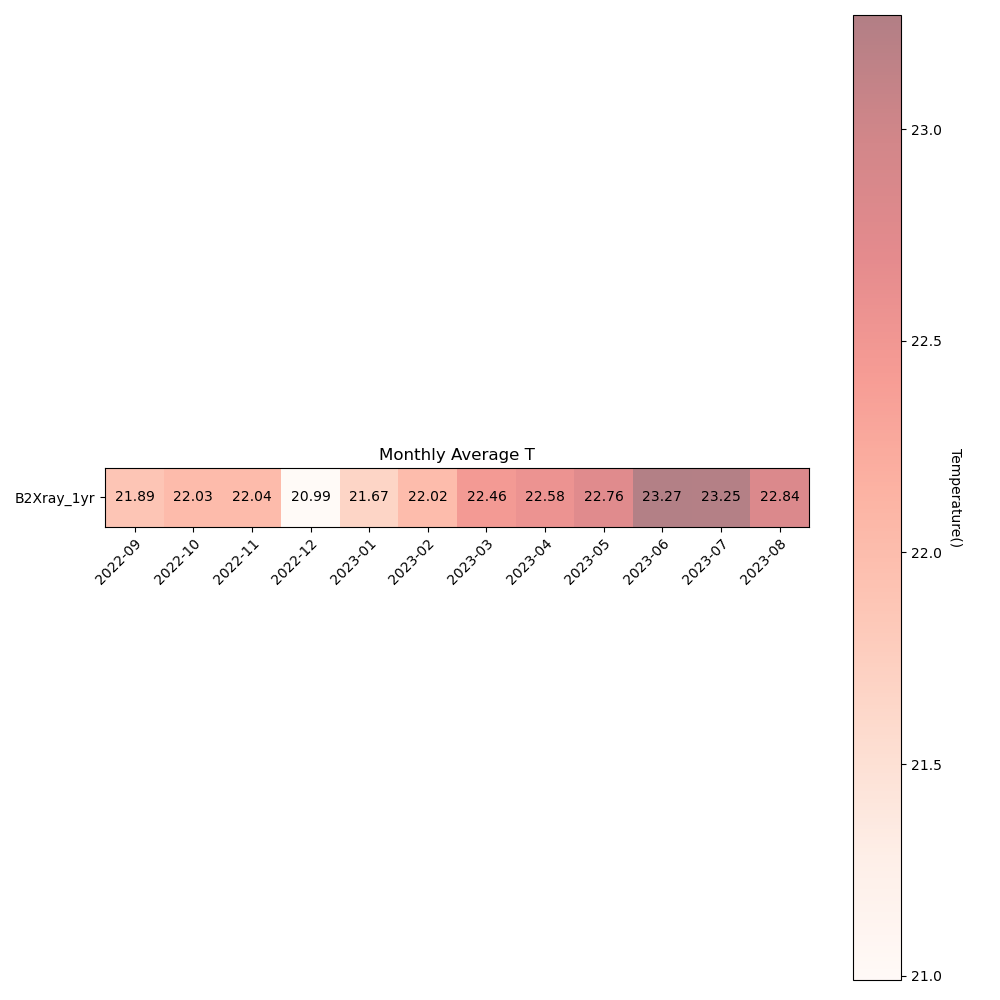

In [16]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt


# dfs[0] = the first sensor
AvT = dfs[0].set_index('DateTime').resample('1M').mean().reset_index().Temp 
Avdate = dfs[0].set_index('DateTime').resample('1M').mean().reset_index().DateTime.dt.strftime('%Y-%m')

np_arr = np.zeros((len(names), len(Avdate)))

print(np_arr)
np_arr[0,] = AvT

#loop
if len(names) > 1:
    for i in range(1,len(names)):
        AvT = dfs[i].set_index('DateTime').resample('1M').mean().reset_index().Temp
        np_arr[i,] = AvT
        
np_arr = np_arr.round(2) #decimal points
fig, ax = plt.subplots(figsize=(10,10))

# im = heat map
im = ax.imshow(np_arr, cmap = 'Reds', interpolation='nearest', alpha=0.5)

ax.set_xticks(np.arange(len(Avdate)), labels=Avdate)
ax.set_yticks(np.arange(len(names)), labels=names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(names)):
    for j in range(len(Avdate)):
        text = ax.text(j, i, np_arr[i, j],
                       ha="center", va="center", color="black")
        
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Temperature()', rotation=-90, va="bottom")
#cbar.ax.set_ylim([18,25])

ax.set_title("Monthly Average T")
fig.tight_layout()
plt.show()
fig.savefig('Heatmap_T')
